# Pylops-distributed - Solvers

In this notebook we investigate the use of pylops-distributed CG and CGLS solvers with distributed operators.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm
import dask
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse.linalg.interface import MatrixLinearOperator, aslinearoperator 
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from dask import persist
from dask.distributed import performance_report

In [2]:
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=1, n_workers=4)
client

Client Scheduler: inproc://10.0.0.156/5625/1 Dashboard: http://10.0.0.156:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


### CG for square systems

Let's just try out the solver using numpy inputs (matrix and vector). As da.xx is never explicitely invoked when ``compute=False`` and ``client=None`` the solver will simply operate on numpy arrays

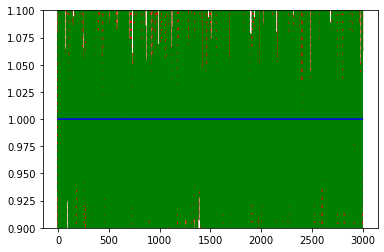

In [3]:
n = 3000
niter = 100 # n * 2
x = np.ones(n)

A = np.random.randn(n, n)
A = np.dot(A.T, A)
#print('eigs', np.linalg.eig(A)[0])

Aop = MatrixLinearOperator(A)
#Aop = aslinearoperator(A)

y = Aop.matvec(x)
xinv_sp = cg(Aop, y, tol=0, maxiter=niter)[0]
xinv = pylops_distributed.optimization.cg.cg(Aop, y, np.zeros_like(x), tol=0, niter=niter)[0]
#print(xinv_sp)
#print(xinv)

plt.figure()
plt.plot(xinv_sp,'r', xinv, '--g', x,'b')
plt.ylim(0.9, 1.1);

And with the LinearOperator

In [4]:
niter = 100

Ada = da.from_array(A, chunks=(n//2, n))
Adaop = pylops_distributed.MatrixMult(Ada, compute=(False, False))

y = Aop * np.ones(n)
yy = Adaop * da.ones(n)

xinv_sp = cg(Aop, y, maxiter=n)[0]
xinv = pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter)[0]
xinv1 = pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, client=client)[0]

print(xinv_sp)
print(xinv)
print(xinv.compute())
print(xinv1.compute())

[0.95852157 0.95237038 1.03109532 ... 1.06702117 1.12299406 1.01216217]
dask.array<add, shape=(3000,), dtype=float64, chunksize=(1500,), chunktype=numpy.ndarray>
[0.97012921 0.93085739 1.07994823 ... 1.19309894 1.21262186 1.06240127]
[0.97012921 0.93085739 1.07994823 ... 1.19309894 1.21262186 1.06240127]


In [5]:
%timeit -n 3 -r 1 cg(Aop, y, maxiter=n)[0]

2.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [6]:
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, compute=True)[0]

19.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [7]:
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, client=client)[0].compute()

19.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [8]:
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cg(Adaop, y, da.zeros(n), tol=0, niter=niter)[0].compute()

16.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [9]:
with performance_report(filename="dask-report-cg_compute.html"):
    pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, compute=True)[0]

In [10]:
with performance_report(filename="dask-report-cg_persist.html"):
    pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, client=client)[0].compute()

In [11]:
with performance_report(filename="dask-report-cg_postponed.html"):
    pylops_distributed.optimization.cg.cg(Adaop, y, da.zeros(n), tol=0, niter=niter)[0].compute()

Let's now persist the data and matrix before running the inversion

In [12]:
Ada = da.from_array(A, chunks=(n//2, n))
yy = Adaop * da.ones(n)

Ada, yy = persist(Ada, yy)
Adaop = pylops_distributed.MatrixMult(Ada, compute=(False, False))

In [13]:
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cg(Adaop, y, da.zeros(n), tol=0, niter=niter)[0].compute()

16.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


### CGLS for rectangular systems

In [14]:
n, m = 1000, 50
x = np.ones(m)

A = np.random.randn(n, m)
Ada = da.from_array(A, chunks=(n//2, m), name='Aop')
Aop = pylops_distributed.MatrixMult(Ada, compute=(False, False))
y = Aop * da.ones(m, name='x')

xinv = pylops_distributed.optimization.cg.cgls(Aop, y, da.zeros(m, name='x0'), m)[0]
xinv.compute()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
#y.visualize(rankdir="LR")
#xinv.visualize(rankdir="LR")

In [16]:
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cgls(Aop, y, da.zeros(m), tol=0, niter=20, compute=True)

3.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [17]:
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cgls(Aop, y, da.zeros(m), tol=0, niter=20, client=client)[0].compute()

3.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [18]:
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cgls(Aop, y, da.zeros(m), tol=0, niter=20)[0].compute()

3.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


## LSQR scipy (suboptimal)

In [19]:
import numpy as np
import dask.array as da
import pylops_distributed
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg.interface import MatrixLinearOperator

n, m = 100, 100
A = da.random.random((n, m), chunks=(n//10, m//10))
#Aop = MatrixLinearOperator(A)
Aop = pylops_distributed.MatrixMult(A)#, compute=(True, True), todask=(True, True))
y = Aop * da.ones(m)

xinv = lsqr(Aop, y, iter_lim=2)[0]
y, xinv

(dask.array<sum-aggregate, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>,
 dask.array<add, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>)

In [20]:
%%time 
xinv = lsqr(Aop, y, iter_lim=2)[0]

CPU times: user 2min 21s, sys: 7.32 s, total: 2min 29s
Wall time: 2min 28s


In [21]:
with performance_report(filename="dask-report-lsqr.html"):
    lsqr(Aop, y, iter_lim=2)[0].compute()

In [22]:
client.close()